# load and inspect suntans mooring data

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

In [2]:
from mitequinox.utils import load_swot_tracks
import pynsitu as pin
crs = pin.maps.crs

# mooring locations
moorings = dict(
    W310 = [122.8370658081835, -14.13718816307405],
    N280 = [123.02928797854348, -14.052341197573492],
    S245 = [123.03041737634493, -14.230653066337094],
    L245 = [123.03312786502875, -14.230660262826481],
)
moorings_pd = (pd.DataFrame(moorings)
               .T
               .rename(columns={0: "longitude", 1: "latitude"})
)

# areas of interest
bounds = dict(cp=(122, 124, -15, -13),
              cp_large=(121, 125, -16, -12),
              central=(118, 125, -18.5, -13),
              ridge=(120.5, 122, -17.5, -15),
              large=(108, 130, -20, -8),
              very_large=(108, 145, -23, -3),
             )

# ------------------------------ plotting ----------------------------------------------------

# kwargs for maps
mapkw_default = dict(extent = bounds["large"], land="10m", coastline="10m", figsize=(8,5))

def map_init(zoom, bathy=None, tracks=True, bathy_kw=None, **kwargs):

    mapkw = dict(**mapkw_default)
    mapkw["extent"] = bounds[zoom]
    if zoom == "cp":
        mapkw.update(land=None,  figsize=(7,7))
        clabel=True
        bathy_lvls = [100, 200, 400, 1000]
    elif zoom == "cp_large":
        mapkw.update(land=None,  figsize=(7,7))
        clabel=True
        bathy_lvls = [100, 200, 400, 1000]
    elif zoom == "central":
        mapkw.update(figsize=(9,7))
        clabel=False
        bathy_lvls = [100, 200, 1000]
    elif zoom == "ridge":
        mapkw.update(figsize=(5,8))
        clabel=False
        bathy_lvls = [100, 200, 1000]
    elif zoom == "large":
        mapkw.update(figsize=(8,5))
        clabel=False
        bathy_lvls = [200, 1000]
    elif zoom == "very_large":
        mapkw.update(figsize=(10,5))
        clabel=False
        bathy_lvls = [200, 1000]

    mapkw.update(projection=pin.maps.ccrs.Robinson(central_longitude=120))
    mapkw.update(**kwargs)

    fig, ax, _ = pin.maps.plot_map(**mapkw)

    if bathy is not None:
        grd, ds = bathy
        bkwargs = dict(clevs=bathy_lvls, filled=False,
            colors="k", linewidths=0.5,
            colorbar=False, transform=crs,
            zorder=10,
        )
        if bathy_kw is not None:
            bkwargs.update(**bathy_kw)
        _, _, tri, _ = grd.suntans.contourf(ds.dv, **bkwargs)
        if clabel:
            ax.clabel(tri, tri.levels, inline=True, fontsize=10) #fmt=fmt

    if tracks:
        plot_swot_tracks(ax)

    return fig, ax

def plot_moorings(ax, moorings=None, **kwargs):
    dkwargs = dict(c="w", s=100, edgecolors="k", marker="*",
                   zorder=30,
                   transform=crs,
                  )
    dkwargs.update(**kwargs)
    moorings_pd.plot.scatter(ax=ax, x="longitude", y="latitude", **dkwargs)
    if moorings is not None:
        for p in moorings.Nc:
            m = moorings.sel(Nc=p)
            ax.scatter(m.lonv, m.latv, **dkwargs)
            #ax.text(lon, lat, f"{int(m.Nc)}", size=10, transform=crs, zorder=20)


def plot_swot_tracks(ax):
    tracks = load_swot_tracks(bbox=(100, 150, -25, 0))["swath"]
    swot_kwargs = dict(
        facecolor="0.7",
        edgecolor="white",
        alpha=0.5,
        zorder=20,
    )
    #if isinstance(swot_tracks, dict):
    #    swot_kwargs.update(swot_tracks)
    proj = ax.projection
    crs_proj4 = proj.proj4_init
    ax.add_geometries(
        tracks.to_crs(crs_proj4)["geometry"],
        crs=proj,
        **swot_kwargs,
    )


In [5]:
nc = "data/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1_S245.nc"
ds = xr.open_dataset(nc, drop_variables="Nk")

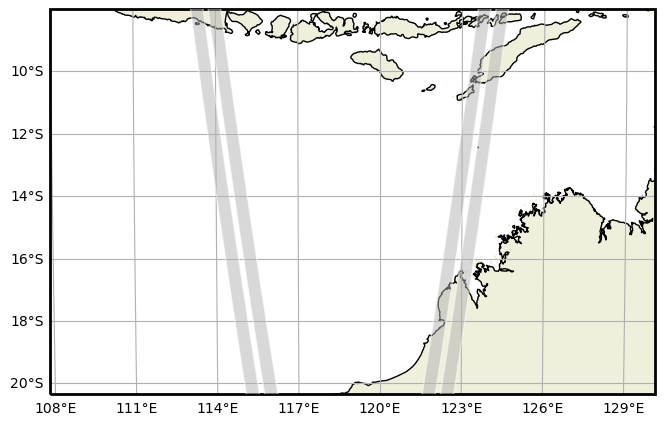

In [10]:
fig, ax = map_init("large", tracks=True)

ax.scatter(ds.xv, ds.yv, s=200, marker="*", transform=crs)

In [12]:
float(ds.xv)

13698061.98083